In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from nicks_plot_utils import *
from lmfit import Model
from lmfit.models import *
from tqdm import tqdm
import logging
logging.getLogger().setLevel(logging.CRITICAL)

from scipy.interpolate import interp1d

COLOR_BLUE=plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
COLOR_RED=plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COLOR_DGREEN=plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
plt.rcParams['legend.title_fontsize'] = 'xx-small'

overlapSettings = {"E99-107": {"name": "E99-107",
                               "color": COLOR_RED,
                               "symbol": '*',
                               "ms" : 10},
                   "kijun": {"name": "K. Park 2014",
                                    "color": COLOR_DGREEN,
                                    "symbol": 'd',
                                "ms": 6},
                   }

which_plot = {
    -1.0: [0, 0],
    -0.8: [0, 1],
    -0.6: [1, 0],
    -0.4: [1, 1],
    -0.2: [2, 0],
    0.0: [2, 1],
    0.2: [3, 0],
    0.4: [3, 1],
    0.6: [4, 0],
    0.8: [4, 1]
}
plot_label = {
    -1.0: "$\cos(\\theta)=[-1.0,-0.8)$",
    -0.8: "$\cos(\\theta)=[-0.8,-0.6)$",
    -0.6: "$\cos(\\theta)=[-0.6,-0.4)$",
    -0.4: "$\cos(\\theta)=[-0.4,-0.2)$",
    -0.2: "$\cos(\\theta)=[-0.2,0.0)$",
    0.0: "$\cos(\\theta)=[0.0,0.2)$",
    0.2: "$\cos(\\theta)=[0.2,0.4)$",
    0.4: "$\cos(\\theta)=[0.4,0.6)$",
    0.6: "$\cos(\\theta)=[0.6,0.8)$",
    0.8: "$\cos(\\theta)=[0.8,1.0)$"
}

from maid_interface import maid_2007_Npi as maid

xs = np.linspace(0,2*np.pi,200)

TOPFAC = 1.5

def get_maid_values(w, q2, theta):
    ENERGY = 4.81726
    crossSections = []
    for phi in xs:
        crossSections.append(maid(ENERGY, w, q2, theta, np.degrees(phi)))

    return np.array(crossSections)


def plot_maid_model(ax, w, q2, theta, name=""):
    # Get the cross section values from maid
    crossSections = get_maid_values(w, q2, theta+0.1)
    # _ax = ax.twinx()
    ax.plot(xs, crossSections, c='r', linestyle='dotted', label=f"{name}")
    # ax.set_ylim(bottom=0, top=np.max(crossSections)*1.5)

    return np.max(crossSections)*TOPFAC


def A(M, B, C):
    if (C > 0 and np.abs(B) <= 4*C):
        return M**2 + B**2/(8*C) + C
    else:
        return M**2 + np.abs(B) - C
    

def model(x, M, b, c):
    """
    a => sigma_l + sigma_t
    b => epsilon*sigma_tt
    c => Sqrt(2epsilon(1+epsilon))* sigma_lt
    """
    f = A(M, b, c) + b * np.cos(2*x) + c * np.cos(x)
    return f

def fit_model(x, y, color, func=model, error=None):
    # Make model from function
    model = Model(func)
    # Make fit parameters
    params = model.make_params()
    # Make sure to set inital values to 1
    # so fit doesn't fail
    for p in params:
        params[p].set(value=1)

    # Fit the model
    try:
        out = model.fit(y, params, x=x, weights=(1.0/error) if error is not None else 1.0)
    except ValueError as e:
        print(e)
        return None
    except TypeError as e:
        print(e)
        return None

    # Plot the fitted model with output parameters and same x's as model
    # ax.plot(xs, out.eval(params=out.params, x=xs), linewidth=2.0, c=color, alpha=1.0)

    return out


In [2]:
dfall = pd.read_csv("/Users/tylern/Data/e1d/crossSections/full_results.csv", index_col=0)
dfall.head()

dfhighw = pd.read_csv("/Users/tylern/Data/e1d/crossSections/results_highw.csv", index_col=0)
dfhighw.head()

df = pd.concat([dfall,dfhighw])

In [3]:
ws = df.w_left.unique()
q2s = df.q2_left.unique()
cts = df.cos_theta.unique()

In [4]:
ws

array([1.1  , 1.12 , 1.14 , 1.16 , 1.18 , 1.2  , 1.22 , 1.24 , 1.26 ,
       1.28 , 1.3  , 1.32 , 1.34 , 1.36 , 1.38 , 1.4  , 1.42 , 1.44 ,
       1.46 , 1.48 , 1.5  , 1.52 , 1.54 , 1.56 , 1.58 , 1.6  , 1.62 ,
       1.64 , 1.66 , 1.68 , 1.7  , 1.72 , 1.74 , 1.76 , 1.78 , 1.8  ,
       1.605, 1.615, 1.625, 1.635, 1.645, 1.655, 1.665, 1.675, 1.685,
       1.695, 1.705, 1.715, 1.725, 1.735, 1.745, 1.755, 1.765, 1.775,
       1.785, 1.795])

In [5]:
def plotCos(w, q2):
    data1 = df[(df.w_left == w) & (df.q2_left == q2)]
    fits = []
    try:
        w_left = data1.w_left.iloc[0]
        w_right = data1.w_right.iloc[0]
        q2_left = data1.q2_left.iloc[0]
        q2_right = data1.q2_right.iloc[0]
    except IndexError:
        w_left = np.nan
        w_right = np.nan
        q2_left = np.nan
        q2_right = np.nan
        
    for cost in np.linspace(-0.99, 0.99, 100):
        out = fit_model(xs, get_maid_values(w, q2, cost), 'k')
        fits.append({
            "w_left" : w_left,
            "w_right" : w_right,
            "q2_left" : q2_left,
            "q2_right" : q2_right,
            "cos_theta_left" : cost,
            "A" : A(out.params['M'],out.params['b'], out.params['c']),
            "B" : out.params['b'].value,
            "C" : out.params['c'].value,
            "data" : False,
            "err" : out.redchi,
        })
    
    # fig, axs = plt.subplots(nrows=5,ncols=2, figsize=[20,10],)
    for ct in cts:
        data =  data1[(data1.cos_theta == ct)]
        
        if data.shape[0] == 0:
            continue

        errorCut = (data.err < 0.75)
        if np.sum(errorCut) < 4:
            continue

        out = fit_model(data[errorCut].x, data[errorCut].y, 'r', error=data[errorCut].err)
        fits.append({
            "w_left" : w_left,
            "w_right" : w_right,
            "q2_left" : q2_left,
            "q2_right" : q2_right,
            "cos_theta_left" : ct,
            "A" : A(out.params['M'],out.params['b'], out.params['c']),
            "B" : out.params['b'].value,
            "C" : out.params['c'].value,
            "data" : True,
            "err" : out.redchi/out.ndata,
        })
        

    return pd.DataFrame(fits)

In [6]:
fits = []
for w in tqdm(ws):
    for q2 in q2s:
        fits.append(plotCos(w, q2))

fits_df = pd.concat(fits)

100%|██████████| 56/56 [07:02<00:00,  7.54s/it]


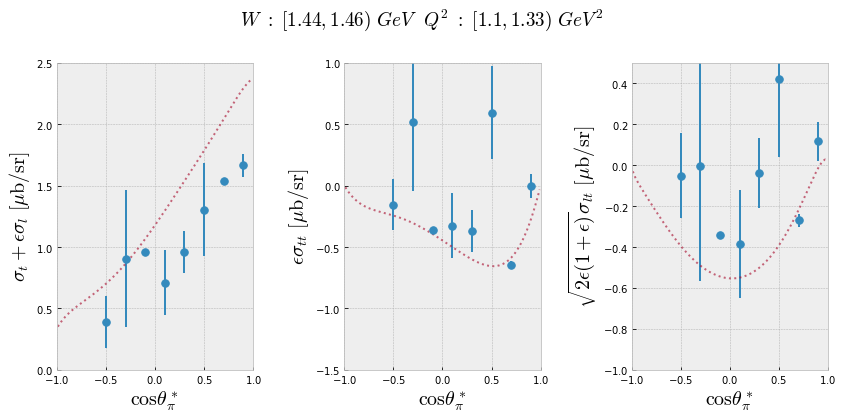

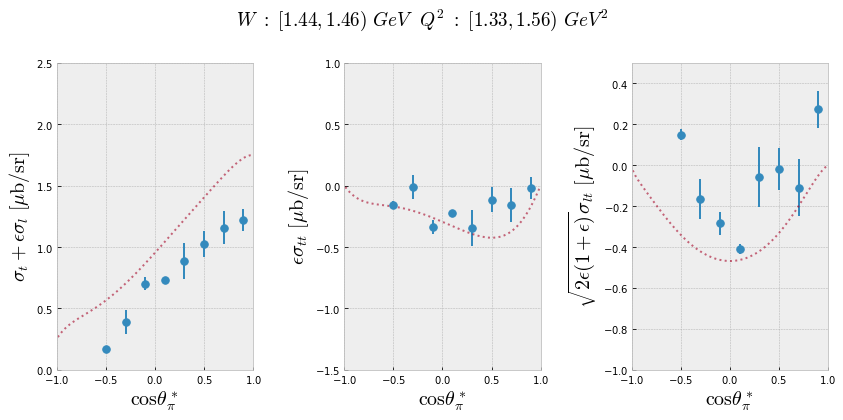

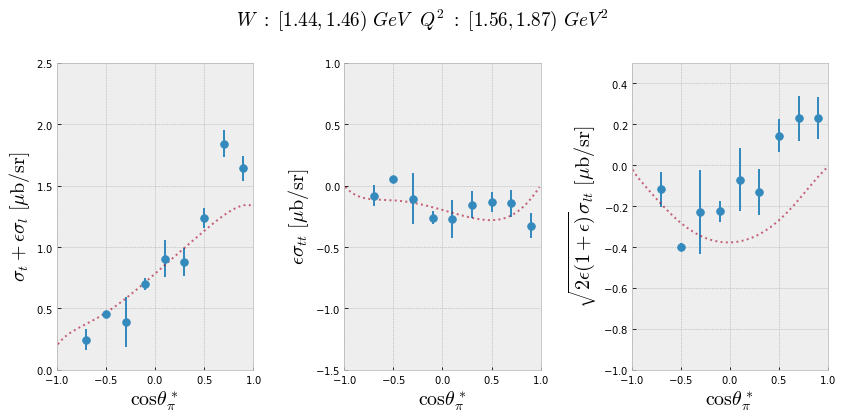

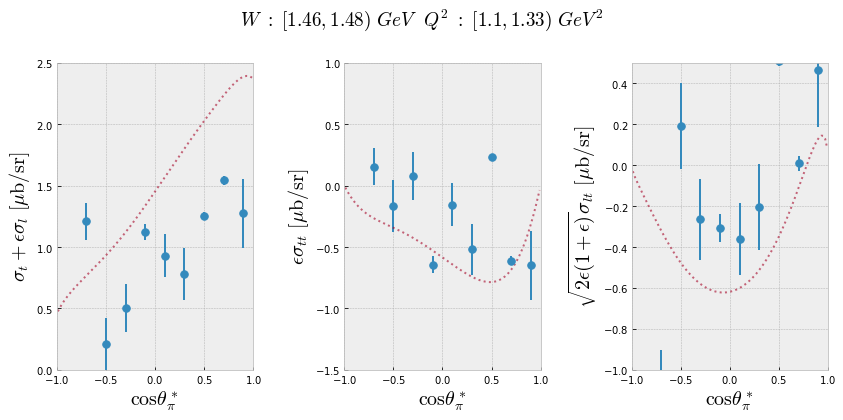

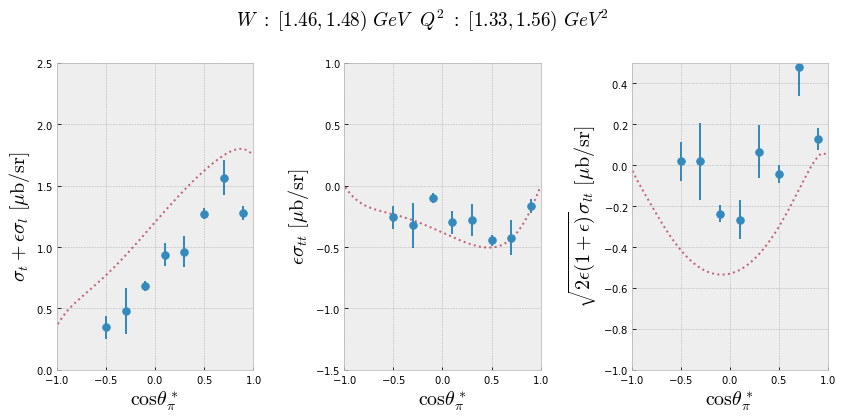

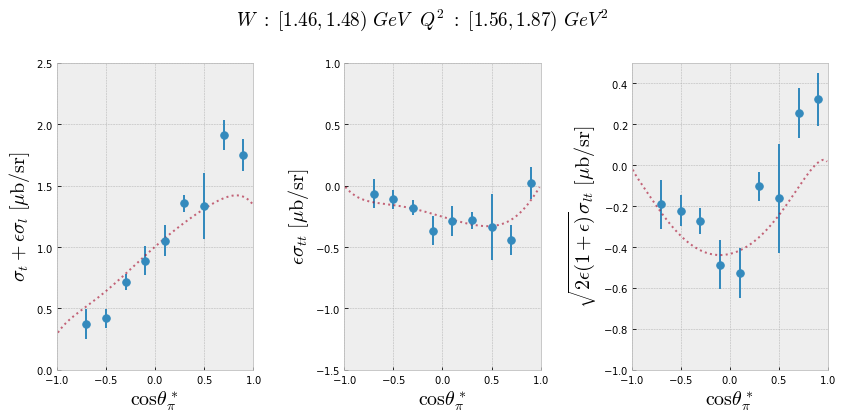

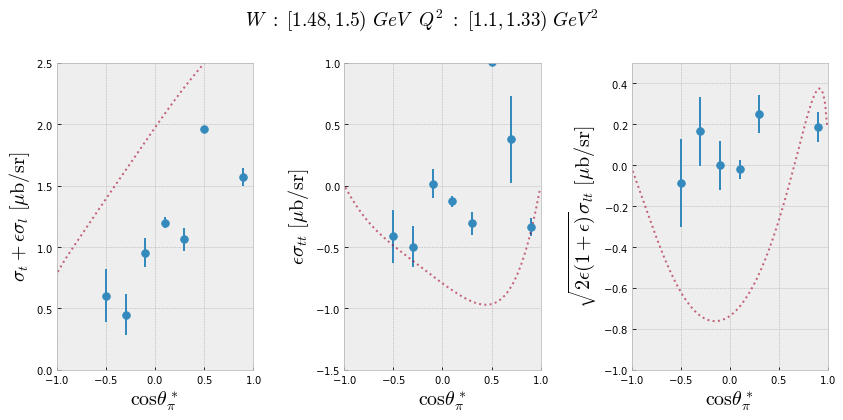

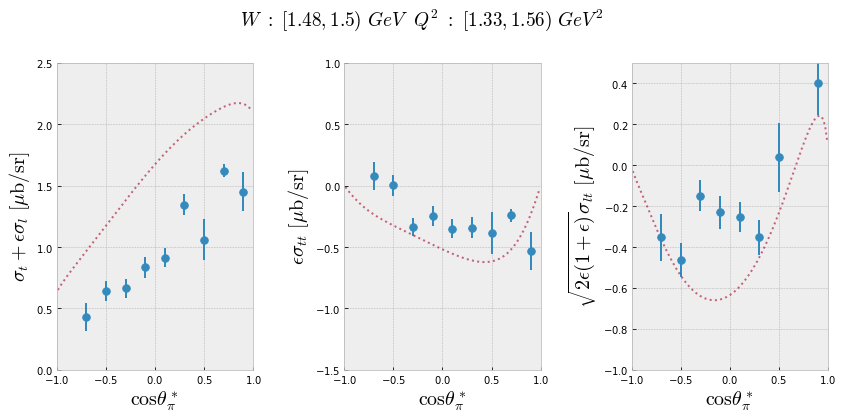

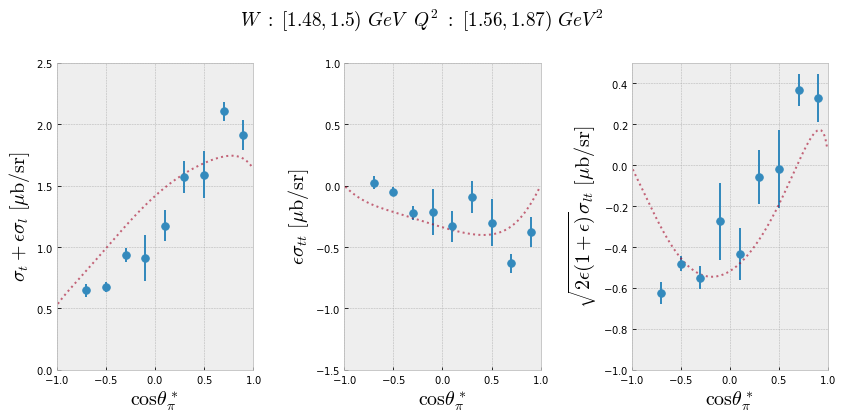

In [7]:
phis = np.linspace(-0.99, 0.99, 500)

fit_ABC = {
    "A" : {"ylim" : (0,2.5),
            "ylabel": "$\sigma_t + \epsilon \sigma_l~[\mu \mathrm{b}/ \mathrm{sr}]$"},
    "B" : {"ylim" : (-1.5,1.00),
            "ylabel": "$\epsilon \sigma_{tt}~[\mu \mathrm{b}/ \mathrm{sr}]$"},
    "C" : {"ylim" : (-1.0,0.5),
            "ylabel": "$\sqrt{2\epsilon (1 + \epsilon )} \sigma_{lt}~[\mu \mathrm{b}/ \mathrm{sr}]$"},
}
for w in [1.44, 1.46, 1.48]:
    for q2 in [1.1, 1.33, 1.56]:
        data = fits_df[(fits_df.w_left == w) & (fits_df.q2_left == q2)]
        if len(data[data.data].cos_theta_left) == 0:
                continue
                
        e1d = data[data.data]
        maid2007 = data[~data.data]

        try:
            w_left = data.w_left.iloc[0]
            w_right = data.w_right.iloc[0]
            q2_left = data.q2_left.iloc[0]
            q2_right = data.q2_right.iloc[0]
        except IndexError:
            w_left = np.nan
            w_right = np.nan
            q2_left = np.nan
            q2_right = np.nan

        e1d = e1d[e1d.err < 0.7]
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[12, 6])

        fit_ABC = {
            "A" : {"ylim" : (0,2.5),
                    "ylabel": "$\sigma_t + \epsilon \sigma_l~[\mu \mathrm{b}/ \mathrm{sr}]$",
                    "ax" : axs[0]},
            "B" : {"ylim" : (-1.5,1.00),
                    "ylabel": "$\epsilon \sigma_{tt}~[\mu \mathrm{b}/ \mathrm{sr}]$",
                    "ax" : axs[1]},
            "C" : {"ylim" : (-1.0,0.5),
                    "ylabel": "$\sqrt{2\epsilon (1 + \epsilon )} \sigma_{lt}~[\mu \mathrm{b}/ \mathrm{sr}]$",
                    "ax" : axs[2]},
        }
        for ABC, values in fit_ABC.items():
                

            ebar = values['ax'].errorbar(e1d.cos_theta_left+0.1, e1d[f"{ABC}"], yerr=e1d.err, 
                         label=f"$E1D$", fmt='.', ms=15)
            
            model = interp1d(maid2007.cos_theta_left, maid2007[f"{ABC}"])
            values['ax'].plot(phis, model(phis), label=f"MAID2007", alpha=0.6, linestyle='dotted')

            coeffs = np.polynomial.legendre.legfit(e1d.cos_theta_left+0.1, e1d[f"{ABC}"], 3, w=1/e1d.err)
            # values['ax'].plot(phis, np.polynomial.legendre.legval(phis, coeffs), alpha=0.4, c=ebar[0].get_color())

            values['ax'].set_xlim(-1.0,1.0)
            values['ax'].set_ylabel(values["ylabel"])
            values['ax'].set_xlabel(r"$\cos{\theta^*_{\pi}}$")
            values['ax'].set_ylim(values['ylim'])
            
        plt.suptitle(f"$W~:~[{w_left},{w_right})~GeV~~Q^2~:~[{q2_left},{q2_right})~GeV^2$")
        # plt.legend()
        plt.tight_layout()
        